In [40]:
def huber_approx_obj(preds, dtrain):
    d = preds - dtrain.get_label()
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [21]:
def jrmse(predt: np.ndarray, dtrain: xgb.DMatrix):
    ''' Root mean squared error metric.'''
    y = dtrain.get_label()
    elements = np.power((np.power(y,2) - np.power(predt,2)), 2)
    return 'JRMSE', float(np.sqrt(np.sum(elements) / len(y)))

In [36]:
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix):
    '''Compute the gradient squared error.'''
    y = dtrain.get_label()
    return np.power((np.power(y,2) - np.power(predt,2)), 2)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix):
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return np.power((predt-y),2)

def jsme(predt: np.ndarray,
                dtrain: xgb.DMatrix):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [127]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pickle
from sklearn.externals import joblib 

In [244]:
def week_login(data):
    for i in range(0,4):    
        data['week'+str(i+1)+'_log'] = (data[str(i+1)] + data[str(i+2)] + data[str(i+3)] + data[str(i+4)] + data[str(i+5)] + data[str(i+6)] + data[str(i+7)]) / 7
        
    data = data.drop(['1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'], axis=1)

    return data

In [245]:
# 데이터 만들기
data = pd.read_csv('./merge_all_flatten.csv')
train_label = pd.read_csv('./train_label_add.csv')
train_label = train_label.sort_values('acc_id')
del data['minus']
del data['plus']
data = week_login(data)
data_lbl = pd.merge(data, train_label, on='acc_id')

xgb의 loss(rmse)에 log 등을 곱해서 가중치를 주어서 헤비 이탈 유저의 예측력을 높인다 : 목적은 기대이익 극대화

In [396]:
# 과금 유저만 대상으로 학습
data_lbl['spent_1'] = np.where(data_lbl['survival_time']==64, 1, 0) # 일평균 결제량이 1 이상이면 1, 아니면 0

data_64 = data_lbl[data_lbl['survival_time']!=64].drop([ 'survival_time', 'amount_spent_y', 'secession',
       'total_spent', 'spent_1'], axis=1)

In [398]:
del data_64['w_survival_time']

In [399]:
data_64.columns

Index(['acc_id', 'temp_cnt_x', 'private_shop', 'level_x', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt_x', 'random_defender_cnt_x',
       'same_pledge_cnt_x', 'etc_cnt_x',
       ...
       'combat_play_time_4', 'pledge_rank_4', 'amount_spent_1',
       'amount_spent_2', 'amount_spent_3', 'amount_spent_4', 'week1_log',
       'week2_log', 'week3_log', 'week4_log'],
      dtype='object', length=377)

In [408]:
# 가중치
data_lbl['w_survival_time'] = np.where(data_lbl['survival_time']<32, np.log((32- data_lbl['survival_time']))*(data_lbl['survival_time']-32)+107, np.log((data_lbl['survival_time']-32))*(data_lbl['survival_time']-32)+107)


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [ ]:
# 가중치
data_lbl['w_survival_time'] = np.where(data_lbl['survival_time']<32, np.log((32- data_lbl['survival_time']))*(data_lbl['survival_time']), np.log((data_lbl['survival_time']-32+1))*(data_lbl['survival_time']))

In [409]:
from sklearn.model_selection import train_test_split
# 


X_train_ta, X_test_ta, y_train_ta, y_test_ta = train_test_split(data_64[data_64.columns[1:]], data_lbl[data_lbl['survival_time']!=64]['w_survival_time'], test_size=0.2, random_state=42)


X_train_ta.shape, X_test_ta.shape,y_train_ta.shape, y_test_ta.shape

((14403, 376), (3601, 376), (14403,), (3601,))

In [410]:
%%time
# 총 결제량 가중치 로그*1.5 회귀 분석
from sklearn.model_selection import KFold

#threshholds = ["0.5*mean","0.6*mean","0.7*mean","0.8*mean","0.9*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean"]
threshholds =["mean"]
# save list
features_index = []
features_name = []
predict_value = []
i=0
for thresh in threshholds:
    model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.1, 
      min_child_weight = 10,
      nthread = 15,
      max_depth= 50,
      subsample= 0.5,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=500,
      max_leaves=300)

    select_ta = SelectFromModel(model_ta, threshold=thresh)
    select_ta.fit(X_train_ta,y_train_ta)

    X_train_s1_ta = select_ta.transform(X_train_ta)
    X_test_s1_ta = select_ta.transform(X_test_ta)
  
    print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  
    # feature name save
    feature_idx_all = select_ta.get_support()
    feature_name_all = data_0[data_0.columns[1:]].columns[feature_idx_all]
  
    # k_fold
    X = X_train_s1_ta
    y = y_train_ta
    y= y.reset_index(drop=True)


    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    kf.get_n_splits(X)

    print(kf)  

    KFold(n_splits=5, random_state=42, shuffle=True)
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    dtest = xgb.DMatrix(X_test_s1_ta)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

  # parameters
    xgb_pars = {'learning_rate': 0.01, 
      'gamma' : 0, 
      'min_child_weight' : 1,
      'nthread' : 15,
      'max_depth' : 50,
      'subsample' : 0.5,
      'eval_metric' : 'rmse',
      'colsample_bytree' : 0.6, 
      'num_boost_round' : 500,
      'n_estimators': 500,
      'max_leaves': 300,
      'objective': 'reg:squarederror'}
    model = xgb.train(xgb_pars, dtrain, 1500,  watchlist,maximize=False, 
                        early_stopping_rounds = 50, verbose_eval=50)
    # 모델 저장
    file_name = './total_select/surv_model'+str(i)+'.pkl' 
    joblib.dump(model, file_name)
    
    file_name = './total_select/surv_selector'+str(i)+'.pkl' 
    joblib.dump(select_ta, file_name)
    
    i = i + 1
  #
    y_pred = model.predict(dtest)
  
  # 값 리스트 저장
    features_index.append(feature_idx_all)
    features_name.append(feature_name_all)
    predict_value.append(y_pred)
  
  
    
    real = y_test_ta.reset_index()
    real['amount_spent_pred'] = y_pred
    linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_survival_time']))
    spent_compare = pd.merge(ind[['index','survival_time']], real, on ='index', how='right')
    linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['survival_time']))

    print("가중치 적용 라벨 rmse: ",linreg_RMSEk_w)
    print("Thresh=%s, n=%d,  rmse: %3f" % (thresh, X_train_s1_ta.shape[1], linreg_RMSEk))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:23:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
X_train_s1.shape : (14403, 153)
KFold(n_splits=5, random_state=42, shuffle=True)


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:76.1403	valid-rmse:73.5536
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:55.0656	valid-rmse:58.8065
[100]	train-rmse:41.1531	valid-rmse:51.512
[150]	train-rmse:31.6779	valid-rmse:48.247
[200]	train-rmse:24.9656	valid-rmse:46.8485
[250]	train-rmse:20.0991	valid-rmse:46.2388
[300]	train-rmse:16.3898	valid-rmse:46.0554
[350]	train-rmse:13.5411	valid-rmse:46.0255
[400]	train-rmse:11.2858	valid-rmse:46.0268
Stopping. Best iteration:
[369]	train-rmse:12.612	valid-rmse:46.0153

가중치 적용 라벨 rmse:  46.39832578802242
Thresh=mean, n=153,  rmse: 37.098684
Wall time: 5min 18s


46.39832578802242


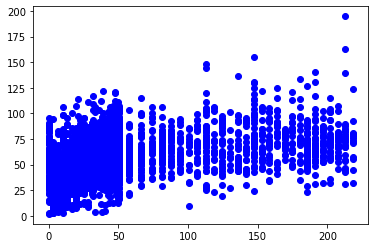

In [411]:
real = y_test_ta.reset_index()
real['amount_spent_pred'] = predict_value[0]
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_survival_time']))
spent_compare = pd.merge(ind[['index','survival_time']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['survival_time']))
print(linreg_RMSEk_w)
plt.plot(real['w_survival_time'],real['amount_spent_pred'],'bo')
#plt.axis([-30, 70, 0, 70]); plt.show()

In [412]:
spent_compare['minus_survival'].hist()

KeyError: 'minus_survival'

37.09868400892089


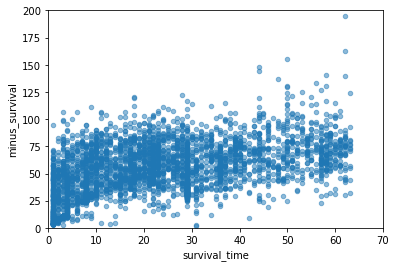

In [503]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','survival_time']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['survival_time']))
spent_compare['minus_survival'] = spent_compare['amount_spent_pred']
print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='survival_time', y = 'minus_survival',alpha= 0.5)
plt.axis([0, 70, 0, 200]); plt.show()

37.09868400892089


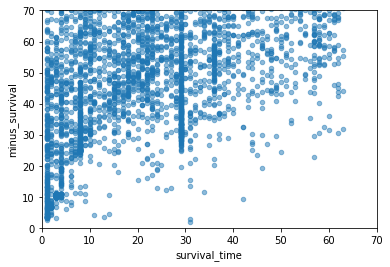

In [426]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','survival_time']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['survival_time']))
spent_compare['minus_survival'] = spent_compare['amount_spent_pred']
print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='survival_time', y = 'minus_survival',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

In [431]:
survival_log = spent_compare[['index','survival_time','minus_survival']]
survival_log['minus_survival'] = survival_log['minus_survival'] - 32
survival_log['survival_time'] = np.where(survival_log['minus_survival']<=0, 1, np.where(survival_log['minus_survival']>=64, 63, survival_log['minus_survival']))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [432]:
survival_log['survival_time_real'] = spent_compare['survival_time']

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [501]:
data_lbl[['survival_time', 'w_survival_time']]

,survival_time,w_survival_time
0,64,223.776484
1,60,202.037750
2,64,223.776484
3,64,223.776484
4,64,223.776484
5,64,223.776484
6,45,118.757580
7,64,223.776484
8,3,10.101887
9,64,223.776484


(array([1021.,  308.,  353.,  365.,  338.,  325.,  289.,  240.,  142.,
         220.]),
 array([8.4304810e-03, 6.3878922e+00, 1.2767354e+01, 1.9146816e+01,
        2.5526278e+01, 3.1905739e+01, 3.8285202e+01, 4.4664661e+01,
        5.1044125e+01, 5.7423584e+01, 6.3803047e+01], dtype=float32),
 <a list of 10 Patch objects>)

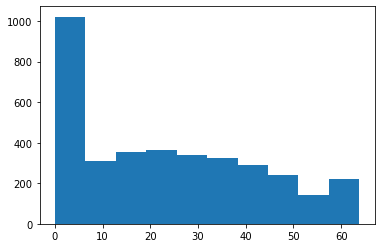

In [433]:
plt.hist(survival_log['survival_time'])

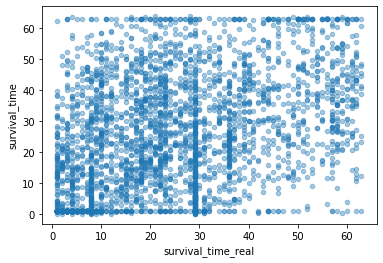

In [434]:
survival_log.plot(kind='scatter',x= 'survival_time_real', y= 'survival_time', alpha=0.4)

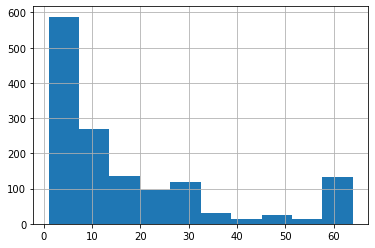

In [312]:
survival_log[survival_log['survival_time']<=5]['survival_time_real'].hist()

In [313]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = './surv_mean_log.pkl' 

joblib.dump(model, file_name)

['./surv_mean_log.pkl']

In [314]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = './select_surv_mean_log.pkl' 

joblib.dump(select_ta, file_name)

['./select_surv_mean_log.pkl']

# test

In [435]:
test1 = pd.read_csv('./merge_all_flatten_test1.csv')    
test2 = pd.read_csv('./merge_all_flatten_test2.csv') 

In [436]:
test1 = week_login(test1)
test2 = week_login(test2)

In [437]:
## 변수 선택 후 
sel_t1 = select_ta.transform(test1[test1.columns[1:]])
dtest_tt1 = xgb.DMatrix(sel_t1)
y_pred_t1 = model.predict(dtest_tt1)

sel_t2 = select_ta.transform(test2[test2.columns[1:]])
dtest_tt2 = xgb.DMatrix(sel_t2)
y_pred_t2 = model.predict(dtest_tt2)

In [472]:
# 생존기간 입력
test1_surv = test1[['acc_id']]
test1_surv['survival_time'] = y_pred_t1

test2_surv = test2[['acc_id']]
test2_surv['survival_time'] = y_pred_t2

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


------------

In [473]:
test1_surv['survival_time'] = test1_surv['survival_time'] - 32
test1_surv['survival_time'] = np.where(test1_surv['survival_time']<=0, 1, np.where(test1_surv['survival_time']>=64, 63, test1_surv['survival_time']))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [474]:
test2_surv['survival_time'] = test2_surv['survival_time'] - 32
test2_surv['survival_time'] = np.where(test2_surv['survival_time']<=0, 1, np.where(test2_surv['survival_time']>=64, 63, test2_surv['survival_time']))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [443]:
test1_surv

,acc_id,survival_time
0,7,16.142193
1,15,13.916897
2,16,1.000000
3,18,24.893158
4,19,15.816090
5,22,41.863754
6,24,1.000000
7,28,6.181713
8,39,47.940269
9,51,15.543720


In [475]:
# 소수는 올림
test1_surv['survival_time']  = round(test1_surv['survival_time'])
test2_surv['survival_time']  = round(test2_surv['survival_time'])

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [476]:
# 0 이하는 생존기간 1, 64 이상은 생존기간 64
test1_surv['survival_time'] = np.where(test1_surv['survival_time']<=0, 1, np.where(test1_surv['survival_time']>64, 64, test1_surv['survival_time']))

test2_surv['survival_time'] = np.where(test2_surv['survival_time']<=0, 1, np.where(test2_surv['survival_time']>64, 64, test2_surv['survival_time']))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [477]:
test1_surv.tail()

,acc_id,survival_time
19995,130450,21.0
19996,130454,16.0
19997,130465,1.0
19998,130466,53.0
19999,130474,18.0


In [478]:
test1=pd.read_csv('./drive-download-20190905T143023Z-001/0905/test1_predict_12000모델에_결제량1이상_생존1이면_그룹_1(13464)_1_6가중치.csv')
test2=pd.read_csv('./drive-download-20190905T143023Z-001/0905/test2_predict_12000모델에_결제량1이상_생존1이면_그룹_1(13464)_1_6가중치.csv')

----------------

결제량 1 넘으면 생존기간 1로 했더니 13900, 100점 오름

In [479]:
test1['survival_time_reg'] = test1_surv['survival_time']
test2['survival_time_reg'] = test2_surv['survival_time']

In [480]:
test1[test1['amount_spent']>=1]

,acc_id,survival_time,amount_spent,survival_time_reg
2,16,1,8.756132,1.0
6,24,1,4.119257,1.0
7,28,64,1.369273,6.0
33,153,40,2.748325,20.0
35,159,1,1.623678,6.0
36,166,1,6.403639,1.0
42,206,1,2.782674,30.0
75,478,1,3.546670,1.0
98,662,40,1.732149,1.0
110,752,1,3.692621,9.0


In [481]:
# 회귀는 1인 1이라 한 확률이 높음, 대신 30 이하인데 1이라 한 확률이 높음
# 분류는 64를 64라 한 확률이 높음, 대신 64 미만인데 64라 한 확률이 높음
# 결제량은 1 이상이면 생존기간 1일 확률이 높음
test1['survival_time_reg'] = np.where((test1['amount_spent']>=1) & (test1['survival_time']<=6), 1,test1['survival_time_reg'])
test2['survival_time_reg'] = np.where((test2['amount_spent']>=1 )& (test1['survival_time']<=6), 1,test2['survival_time_reg'])

In [490]:
test1['survival_time_reg'] = np.where((test1['survival_time']==64) & (test1['amount_spent']<=0.5), 64 , test1['survival_time_reg'])
test2['survival_time_reg'] = np.where((test2['survival_time']==64) & (test2['amount_spent']<=0.5), 64 , test2['survival_time_reg'])

In [492]:
test1['survival_time'] = test1['survival_time_reg']
test2['survival_time'] = test2['survival_time_reg']

------------------

In [504]:
test1

,acc_id,survival_time,amount_spent,survival_time_reg
0,7,27.0,0.000000,27.0
1,15,1.0,0.043754,1.0
2,16,1.0,8.756132,1.0
3,18,64.0,0.122310,64.0
4,19,64.0,0.090335,64.0
5,22,64.0,0.095681,64.0
6,24,16.0,4.119257,16.0
7,28,36.0,1.369273,36.0
8,39,64.0,0.193041,64.0
9,51,25.0,0.000000,25.0


In [491]:
test2

,acc_id,survival_time,amount_spent,survival_time_reg
0,1,1,0.070648,27.0
1,3,1,1.263888,1.0
2,9,1,5.000011,1.0
3,14,64,0.759212,38.0
4,26,64,0.009048,64.0
5,27,64,0.016134,64.0
6,32,1,0.112927,16.0
7,44,64,1.634373,36.0
8,45,64,0.027202,64.0
9,49,20,0.007040,25.0


In [493]:
test1[test1['amount_spent']>=1]

,acc_id,survival_time,amount_spent,survival_time_reg
2,16,1.0,8.756132,1.0
6,24,16.0,4.119257,16.0
7,28,36.0,1.369273,36.0
33,153,12.0,2.748325,12.0
35,159,31.0,1.623678,31.0
36,166,1.0,6.403639,1.0
42,206,25.0,2.782674,25.0
75,478,12.0,3.546670,12.0
98,662,21.0,1.732149,21.0
110,752,27.0,3.692621,27.0


-----------

In [494]:
test1['survival_time'] = test1['survival_time_reg']
test2['survival_time'] = test2['survival_time_reg']

In [495]:
# -는 0으로
test1['amount_spent'] = np.where(test1['amount_spent']<0, 0,test1['amount_spent'])

test2['amount_spent'] = np.where(test2['amount_spent']<0, 0,test2['amount_spent'])

In [496]:
# csv 저장
test1.to_csv('./생존기간회귀적용/test1_predict.csv', index=False)
test2.to_csv('./생존기간회귀적용/test2_predict.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000281869C0DD8>,
      dtype=object)

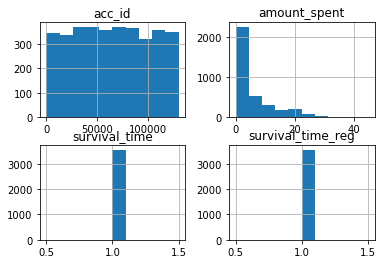

In [498]:
test2[test2['survival_time']==1].hist()

-------------------

13.681158441898546


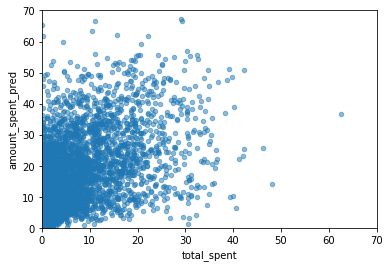

In [144]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

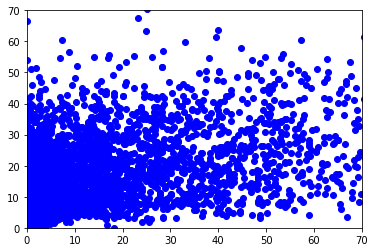

In [139]:
real = y_test_ta.reset_index()
real['amount_spent_pred'] = predict_value[0]
linreg_RMSEk_w = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

13.516226689673397


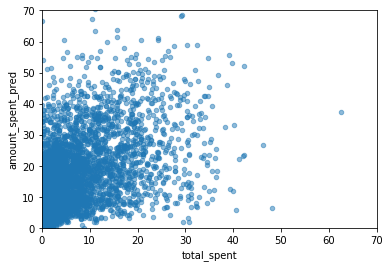

In [140]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

15.08105867158018


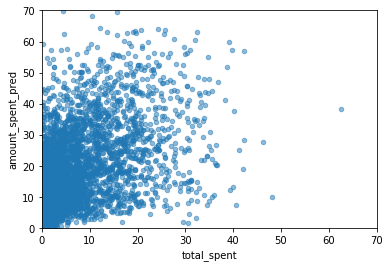

In [136]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

14.632246339849376


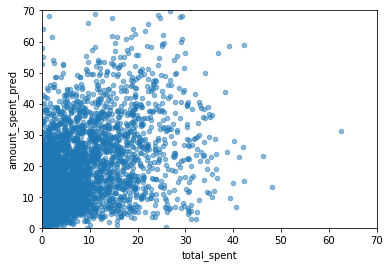

In [134]:
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

KFold(n_splits=5, random_state=None, shuffle=False)


C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:15:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:30.8739	valid-rmse:32.4378
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:27.6718	valid-rmse:30.2034
[40]	train-rmse:25.0605	valid-rmse:28.5156
[60]	train-rmse:22.8875	valid-rmse:27.2666
[80]	train-rmse:21.0952	valid-rmse:26.3584
[99]	train-rmse:19.6637	valid-rmse:25.7456
23.689711172656384


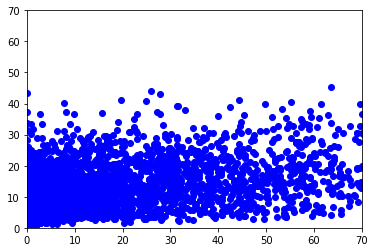

Wall time: 1min 52s


In [124]:
%%time

'''
model_ta = xgb.XGBRegressor(learning_rate= 0.01, 
      gamma = 0.5, 
      min_child_weight = 10,
      max_depth= 15,
      subsample= 0.7,
      eval_metric= 'rmse',
      colsample_bytree= 0.8, 
      n_estimators=100,
     # max_leaves=300
                        )

select_ta = SelectFromModel(model_ta, threshold="0.7*mean")
select_ta.fit(X_train_ta,y_train_ta)

feature_idx_all = select_ta.get_support()
feature_name_all = data[data.columns[1:]].columns[feature_idx_all]


X_train_s1_ta = select_ta.transform(X_train_ta)
X_test_s1_ta = select_ta.transform(X_test_ta)
  
print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
'''

X = X_train_ta.values
y = y_train_ta
y= y.reset_index(drop=True)


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test_ta.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'learning_rate': 0.01, 
    'gamma' : 0.5, 
    'min_child_weight' : 10,
    #'nthread' : 15,
    'max_depth' : 15,
    'subsample' : 0.7,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 1500,
    'n_estimators': 500,
    #'max_leaves': 300,
    'objective': 'reg:linear'
           }
model_ta = xgb.train(xgb_pars, dtrain, 100, watchlist  ,early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)
#plt.figure(figsize=(15,10))
y_pred = model_ta.predict(dtest)

a.append(feature_idx_all)
b.append(feature_name_all)
c.append(y_pred)

real = y_test_ta.reset_index()
real['amount_spent_pred'] = y_pred

linreg_RMSEk = np.sqrt(mse(real['amount_spent_pred'], real['w_amount_spent']))

print(linreg_RMSEk)
plt.plot(real['w_amount_spent'],real['amount_spent_pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()

In [126]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
a = 's'
file_name = './tt'+a+'.pkl' 

joblib.dump(model_ta, file_name)

['./tts.pkl']

8.711474123470525


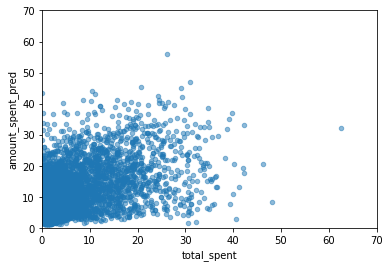

In [125]:
# 전체 특성,  log 가중치 0.85, 과금 유저
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

7.556665364385848


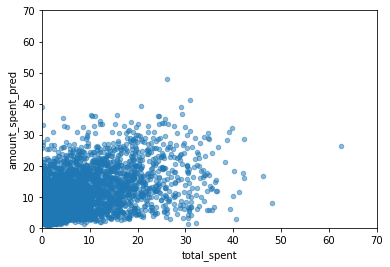

In [122]:
# 전체 특성,  log 가중치 0.85, 과금 유저
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

6.021973846990132


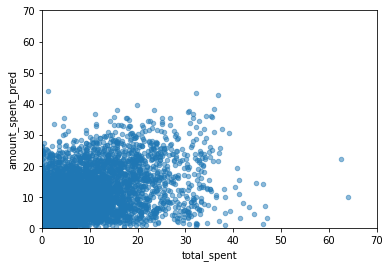

In [112]:
# 전체 특성,  log 가중치 0.85
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

5.818376818879185


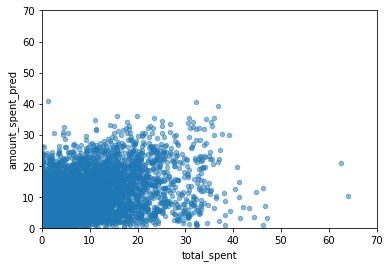

In [109]:
# 전체 특성,  log 가중치 0.8
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

11.114384383356612


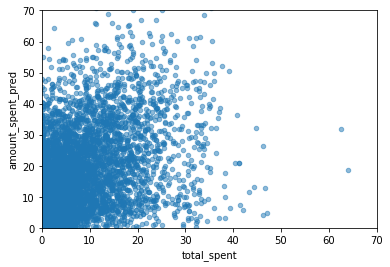

In [98]:
# 1.2eman, feature= 29개, log 가중치
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

11.114384383356612


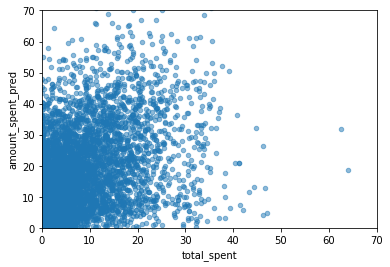

In [96]:
# 전체 유저 log*3한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','total_spent']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['total_spent']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='total_spent', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

3.309614024363015


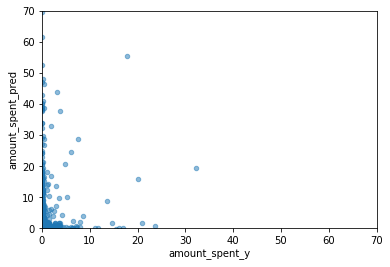

In [76]:
# 전체 유저 log*3한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

3.1313193538364357


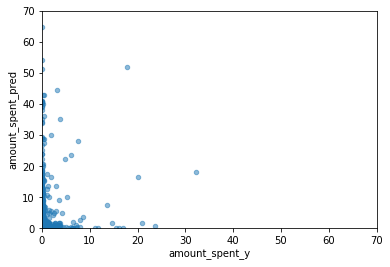

In [72]:
# 전체 유저 log*5한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

1.9181817920007205


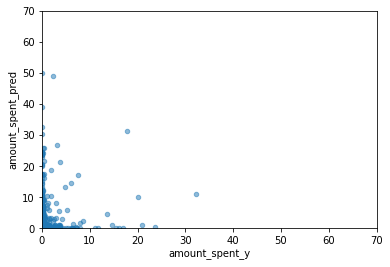

In [69]:
# 전체 유저 log*3한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

1.0858655141730662


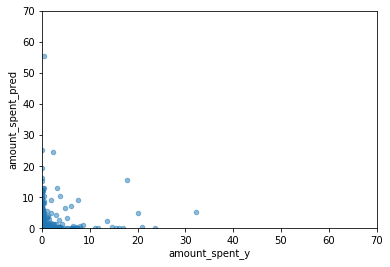

In [48]:
# 전체 유저 log*1.8 한 경우
ind = data_lbl.reset_index()
spent_compare = pd.merge(ind[['index','amount_spent_y']], real, on ='index', how='right')
linreg_RMSEk = np.sqrt(mse(spent_compare['amount_spent_pred'], spent_compare['amount_spent_y']))

print(linreg_RMSEk)
spent_compare.plot(kind='scatter', x='amount_spent_y', y = 'amount_spent_pred',alpha= 0.5)
plt.axis([0, 70, 0, 70]); plt.show()

test(9900점 나온 테스트)

In [77]:
test1 = pd.read_csv('./merge_all_flatten_test1.csv')    
test2 = pd.read_csv('./merge_all_flatten_test2.csv')

test1 = week_login(test1)

test2 = week_login(test2)

In [97]:
s_t1.shape

(20000, 89)

In [78]:
s_t1 = select_ta.transform(test1[test1.columns[1:]])
dtest_t1 = xgb.DMatrix(s_t1)

result1 = model_ta.predict(dtest_t1)

In [79]:
s_t2 = select_ta.transform(test2[test2.columns[1:]])
dtest_t2 = xgb.DMatrix(s_t2)

result2 = model_ta.predict(dtest_t2)

In [80]:
test1_predict = test1[['acc_id']]
test1_predict['amount_spent'] = result1

test2_predict = test2[['acc_id']]
test2_predict['amount_spent'] = result2

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [81]:
test1_predict['amount_spent'] = np.where(test1_predict['amount_spent']<0, 0,test1_predict['amount_spent'])

test2_predict['amount_spent'] = np.where(test2_predict['amount_spent']<0, 0,test2_predict['amount_spent'])

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([1.9498e+04, 2.2000e+02, 1.0800e+02, 5.3000e+01, 3.7000e+01,
        6.3000e+01, 1.5000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([  0.      ,  18.63255 ,  37.2651  ,  55.897644,  74.5302  ,
         93.16274 , 111.79529 , 130.42784 , 149.0604  , 167.69293 ,
        186.32549 ], dtype=float32),
 <a list of 10 Patch objects>)

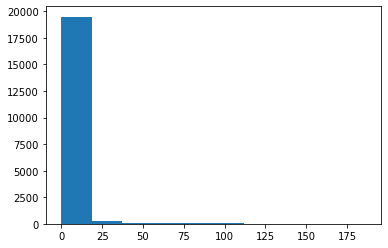

In [100]:
plt.hist(test2_predict['amount_spent'])

In [87]:
test1_predict.to_csv('./0905_일결제량가중치1.5와5900점생존기간조합/test1_predict.csv', index=False)
test2_predict.to_csv('./0905_일결제량가중치1.5와5900점생존기간조합/test2_predict.csv', index=False)


In [89]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = './0905_일결제량가중치1.5와5900점생존기간조합/xgb_am_log_w5.pkl' 

joblib.dump(model_ta, file_name)

['./0905_일결제량가중치1.5와5900점생존기간조합/xgb_am_log_w5.pkl']

In [90]:
# 객체를 pickled binary file 형태로 저장한다 
file_name = './0905_일결제량가중치1.5와5900점생존기간조합/select_am_log_w5_.pkl' 

joblib.dump(select_ta, file_name)

['./0905_일결제량가중치1.5와5900점생존기간조합/select_am_log_w5_.pkl']

In [159]:
np.tan(-1/2)

-0.5463024898437905

In [189]:
np.sqrt(1.11)**(-30)

0.20900434665031922

In [163]:
np.log(40)

3.6888794541139363